In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import plotly.express as px
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from imblearn.combine import SMOTETomek
import shap 
pd.set_option('display.max_columns',30)

C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\Dell\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
train = pd.read_csv('Cleaned_data/Train_dataset.csv', index_col=0)
test = pd.read_csv('Cleaned_data/Test_dataset.csv', index_col=0)
#test = pd.read_csv('Cleaned_data/New_test_dataset.csv', index_col=0)

In [4]:
train.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail'], inplace=True)
test.drop(columns = ['date_x','serial_number','model','failure_x','date_actual_fail','new_date'], inplace=True)
train.head()
train['failure_actual_fail'].value_counts()

0    31277
1      836
Name: failure_actual_fail, dtype: int64

In [5]:
train_features = train.drop(columns=['failure_actual_fail'])
train_y = train[['failure_actual_fail']]
test_features = test.drop(columns=['failure_actual_fail'])
test_y = test[['failure_actual_fail']]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_y, test_size=0.3, random_state = 1)
X_test, test_features, y_test, test_y =  train_test_split(X_test, y_test, test_size=0.5, random_state = 1)

In [7]:
from sklearn.metrics import recall_score
def FNR_calc(mat):
    tn = mat[0,0]
    tp = mat[1,1]
    fn = mat[1,0]
    fp = mat[0,1]
    print(f'tn: {tn}, fp: {fp},\nfn: {fn},   tp: {tp}')
    print(f'FNR: {round(fn/(fn+tp) * 100, 2)}%')
    print(f'Recall: {round(tp/(fn+tp) * 100, 2)}%')
    print(f'Precision: {round(tp/(fp+tp) * 100, 2)}%')
    return fn/(fn+tp)

def matrix_plotter(mat):
    ax = sns.heatmap(mat, annot=True, cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

tn: 4632, fp: 41,
fn: 54,   tp: 90
FNR: 37.5%
Recall: 62.5%
Precision: 68.7%


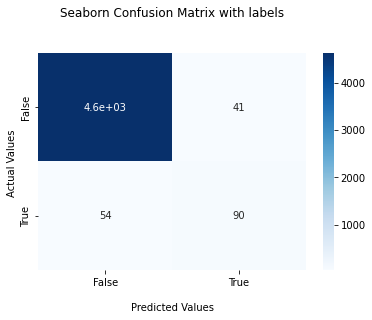

In [8]:
basicOS = RandomOverSampler(sampling_strategy=1, random_state = 2331) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

xgbc = xgb.XGBClassifier(verbosity = 0)
xgbc.fit(train_basicOS, label_basicOS)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

## Hyperparameter

tn: 4632, fp: 41,
fn: 54,   tp: 90
FNR: 37.5%
Recall: 62.5%
Precision: 68.7%


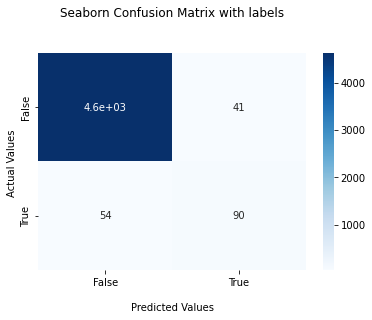

In [11]:
basicOS = RandomOverSampler(sampling_strategy=1, random_state=2331) #can set the proportion of minority/total 
train_basicOS, label_basicOS = basicOS.fit_resample(X_train,y_train)

xgbc = XGBClassifier(verbosity = 0)
xgbc.fit(train_basicOS, label_basicOS)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)

FNR_calc(cf_matrix)
#print(1 - recall_score(y_test, y_pred))
matrix_plotter(cf_matrix)

Learning rate

In [27]:
param_test7 = {
 'learning_rate':[0.05,0.1,0.3,0.5,1]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test7, scoring='recall',n_jobs=2,cv=4)
gsearch7.fit(train_basicOS, label_basicOS)
gsearch7.best_params_, gsearch7.best_score_

({'learning_rate': 0.3}, 1.0)

tn: 4632, fp: 41,
fn: 54,   tp: 90
FNR: 37.5%
Recall: 62.5%
Precision: 68.7%


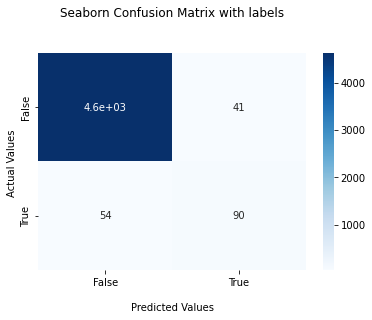

In [28]:
xgbc = gsearch7.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

In [29]:
param_test1 = {
 'max_depth':range(5,11,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='recall',n_jobs=2, cv=4)
gsearch1.fit(train_basicOS, label_basicOS)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 7, 'min_child_weight': 1}, 1.0)

tn: 4644, fp: 29,
fn: 68,   tp: 76
FNR: 47.22%
Recall: 52.78%
Precision: 72.38%


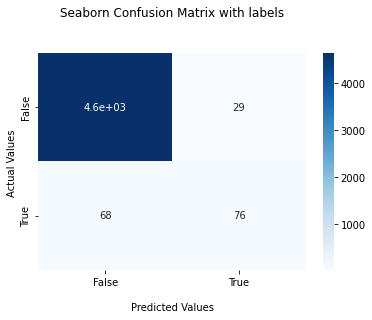

In [30]:
xgbc = gsearch1.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

n_estimators

In [31]:
param_test8 = {
 'n_estimators':[50,200,400,500]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test8, scoring='recall',n_jobs=2,cv=4)
gsearch8.fit(train_basicOS, label_basicOS)
gsearch8.best_params_, gsearch8.best_score_

({'n_estimators': 200}, 1.0)

In [32]:
gsearch8.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=2, nthread=2,
              num_parallel_tree=1, predictor='auto', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

tn: 4648, fp: 33,
fn: 53,   tp: 83
FNR: 38.97%
Recall: 61.03%
Precision: 71.55%


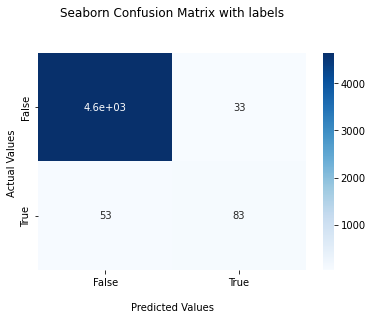

In [33]:
xgbc = gsearch8.best_estimator_
y_pred = xgbc.predict(test_features)
cf_matrix = confusion_matrix(test_y, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

Tune gamma

In [34]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=2, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring='recall',n_jobs=2, cv=4)
gsearch3.fit(train_basicOS, label_basicOS)
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.0}, 1.0)

tn: 4632, fp: 41,
fn: 54,   tp: 90
FNR: 37.5%
Recall: 62.5%
Precision: 68.7%


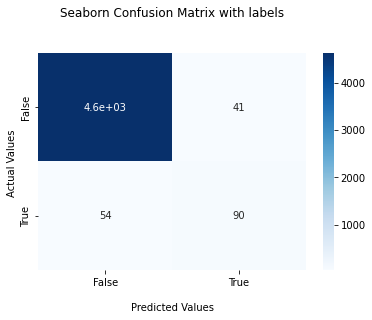

In [35]:
xgbc = gsearch3.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

Tune subsample and colsample_bytree

In [36]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='recall',n_jobs=2, cv=4)
gsearch4.fit(train_basicOS, label_basicOS)
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.6}, 1.0)

tn: 4629, fp: 44,
fn: 54,   tp: 90
FNR: 37.5%
Recall: 62.5%
Precision: 67.16%


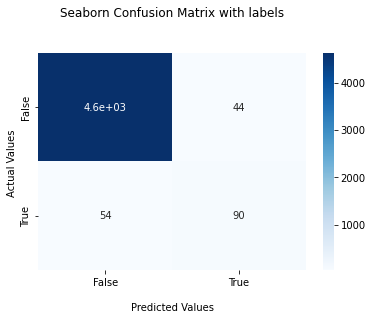

In [37]:
xgbc = gsearch4.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

Tuning Regularization Parameters

In [38]:
param_test5 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test5, scoring='recall',n_jobs=2,cv=4)
gsearch5.fit(train_basicOS, label_basicOS)
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 1e-05}, 1.0)

tn: 4632, fp: 41,
fn: 54,   tp: 90
FNR: 37.5%
Recall: 62.5%
Precision: 68.7%


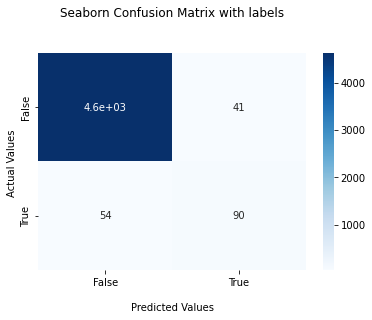

In [39]:
xgbc = gsearch5.best_estimator_
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

## Validation set (Tune the reg_alpha to see varying results)

tn: 4438, fp: 235,
fn: 33,   tp: 111
FNR: 22.92%
Recall: 77.08%
Precision: 32.08%


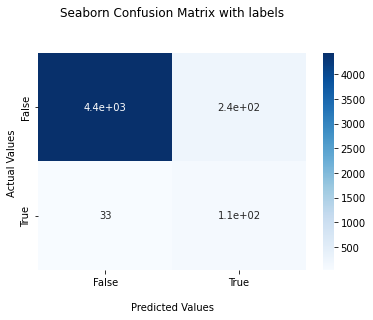

In [69]:
xgbc = XGBClassifier(objective= 'binary:logistic', scale_pos_weight=1, seed=27, learning_rate = 0.3, 
max_depth=7, min_child_weight=5, n_estimators=200, gamma=0, colsample_bytree=0.6, subsample=0.6, 
reg_alpha=50)
xgbc.fit(train_basicOS,label_basicOS)
y_pred = xgbc.predict(X_test)
cf_matrix = confusion_matrix(y_test, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

## Test set

tn: 4435, fp: 246,
fn: 25,   tp: 111
FNR: 18.38%
Recall: 81.62%
Precision: 31.09%


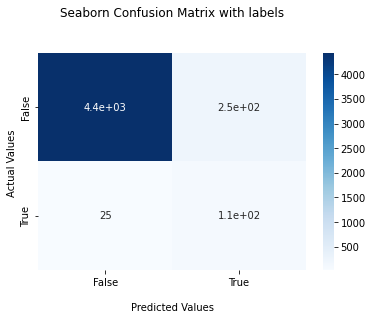

In [70]:
y_pred = xgbc.predict(test_features)
cf_matrix = confusion_matrix(test_y, y_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)